In [58]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from shapely.geometry import Point
from sklearn.neighbors import KNeighborsRegressor
import rasterio as rst
from rasterstats import zonal_stats
import matplotlib.cm as cm

Index(['OBJECTID', 'LA code', 'LAD21NM', 'BNG_E', 'BNG_N', 'LONG', 'LAT',
       'SHAPE_Leng', 'SHAPE_Area', 'geometry', 'Unnamed: 0.1', 'Ofsted Avg',
       'lonely_avg', 'KS2 metrics PCA', 'GDHI income index', 'LA name',
       'LA flow rate', 'All Ages', 'meds', 'old%', 'young%', 'Unnamed: 0',
       '3rd Pref %P', 'Non Preferred Offer %P', 'No Offer %P',
       'Offer in diff LA code %P', '3rd Pref %S', 'Non Preferred Offer %S',
       'No Offer %S', 'Offer in diff LA code %S', 'FSM Eligible %',
       '<2 A levels', '< AAB', 'perm_excl_rate', 'Unsuccessful Appeals',
       '% of ppl not doing degrees', 'progression_rate', 'total_pop'],
      dtype='object')


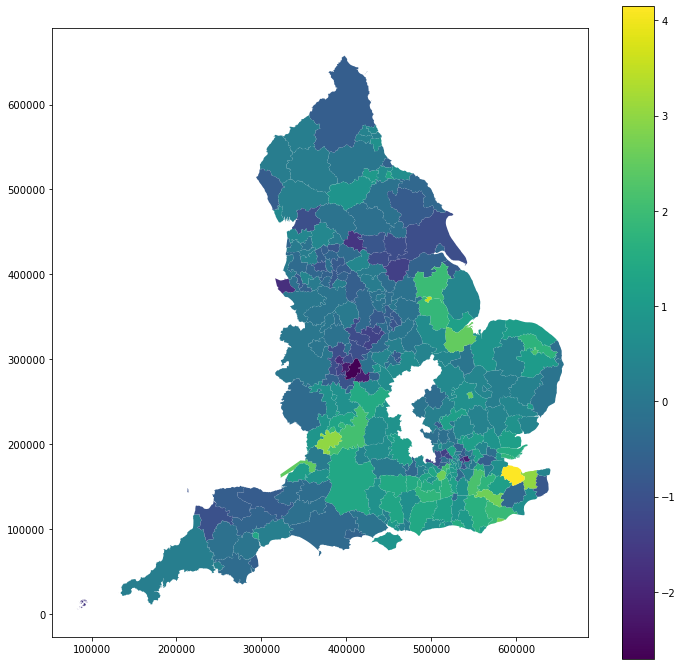

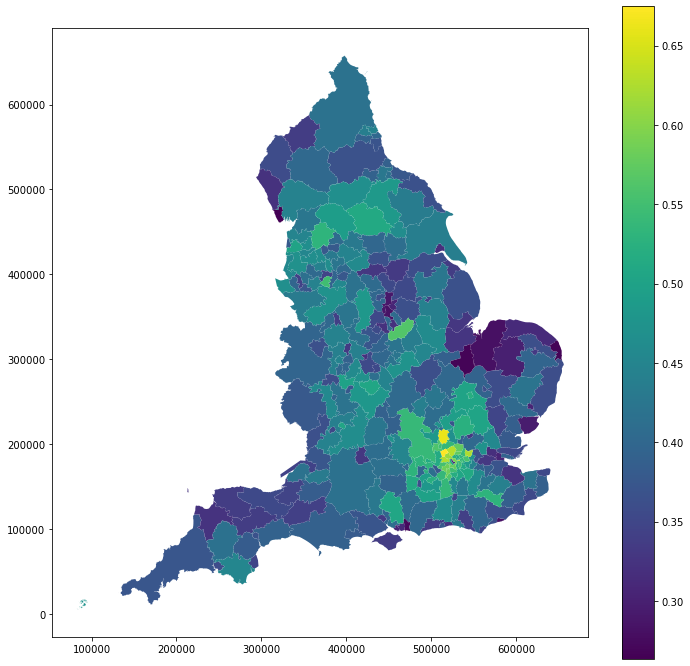

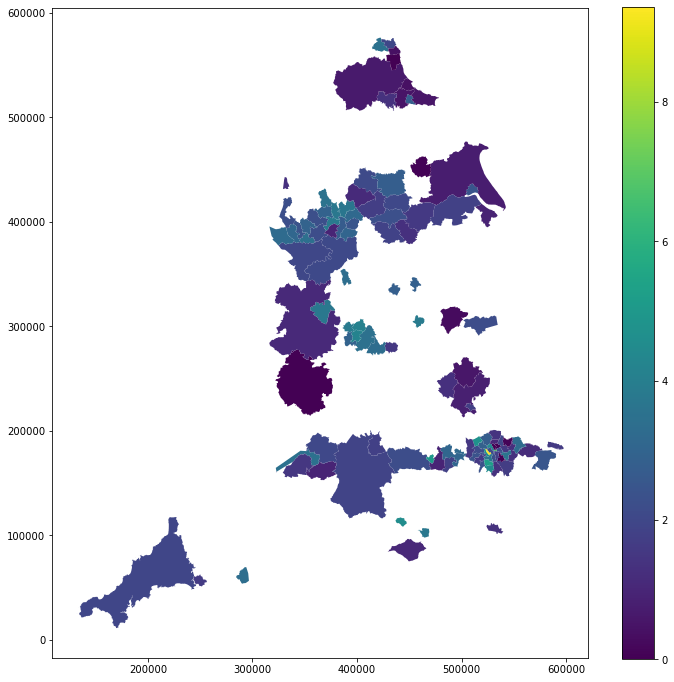

In [72]:
LA_area_map = gpd.read_file('LAD_MAY_2021_UK_BFE_V2.shp')
master_df = pd.read_csv('C:/Users/Jonathan/OneDrive - University of Bristol/CS/AppliedDataScience/Coursework/ADS-Loneliness/master_df.csv')
#progression_df = pd.read_csv('C:/Users/Jonathan/OneDrive - University of Bristol/CS/AppliedDataScience/Coursework/ADS-Loneliness/Tundra(progression_rates)/outputDataframe.csv')
LA_area_map = LA_area_map.rename(columns={'LAD21CD':'LA code'})
map_df =LA_area_map.merge(master_df, on='LA code')
type(map_df)
fig,ax = plt.subplots(figsize=(12,12))
map_df.plot(ax=ax,column='lonely_avg',legend=True)
fig,ax = plt.subplots(figsize=(12,12))
map_df.plot(ax=ax,column='progression_rate',legend=True)
fig,ax = plt.subplots(figsize=(12,12))
map_df.plot(ax=ax,column='Non Preferred Offer %P',legend=True)



print(map_df.columns)


In [28]:
#Create a function that takes a column and creates a colour mapping for it
def colormap(df,col_name):
    min_val = min(df[col_name])
    max_val = max(df[col_name])
    norm = matplotlib.colors.Normalize(vmin=min_val,vmax=max_val,clip=True)
    mapper = cm.ScalarMappable(norm=norm,cmap='viridis')
    df[col_name+'_color'] = df[col_name].apply(lambda x: mapper.to_rgba(x))
    return df

In [29]:
colored_df = colormap(map_df,'lonely_avg')
colored_df.head()

,OBJECTID,LAD21CD,LAD21NM,BNG_E,BNG_N,LONG,LAT,SHAPE_Leng,SHAPE_Area,geometry,...,FSM Eligible %,<2 A levels,< AAB,perm_excl_rate,Unsuccessful Appeals,% of ppl not doing degrees,progression_rate,total_pop,lonely_avg color,lonely_avg_color
0,3,E06000003,Redcar and Cleveland,464361,519597,-1.00608,54.567520,105292.103526,2.537854e+08,"POLYGON ((455525.931 528406.654, 455724.632 52...",...,17.971133,23.263,86.907,26.902558,58.2,23.0,0.374421,7550.0,"(0.180653, 0.701402, 0.488189, 1.0)","(0.180653, 0.701402, 0.488189, 1.0)"
1,4,E06000004,Stockton-on-Tees,444940,518183,-1.30664,54.556911,108085.190140,2.097308e+08,"POLYGON ((444157.002 527956.304, 444165.898 52...",...,16.438313,22.014,81.560,12.734798,71.0,22.7,0.427333,10385.0,"(0.175707, 0.6979, 0.491033, 1.0)","(0.175707, 0.6979, 0.491033, 1.0)"
2,5,E06000005,Darlington,428029,515648,-1.56835,54.535339,107203.152334,1.974778e+08,"POLYGON ((423496.602 524724.299, 423497.204 52...",...,16.558996,23.524,82.458,6.176271,71.2,35.8,0.390533,5635.0,"(0.281477, 0.755203, 0.432552, 1.0)","(0.281477, 0.755203, 0.432552, 1.0)"
3,7,E06000007,Warrington,362744,388456,-2.56167,53.391628,84154.547834,1.823836e+08,"POLYGON ((367308.201 398265.497, 367315.399 39...",...,10.993291,39.531,87.766,2.481928,76.1,47.8,0.445360,11660.0,"(0.119512, 0.607464, 0.540218, 1.0)","(0.119512, 0.607464, 0.540218, 1.0)"
4,8,E06000008,Blackburn with Darwen,369490,422806,-2.46360,53.700802,65284.952318,1.370221e+08,"POLYGON ((369226.299 431801.198, 369234.000 43...",...,15.195916,20.973,89.454,3.346471,86.7,35.4,0.465333,8990.0,"(0.166617, 0.463708, 0.558119, 1.0)","(0.166617, 0.463708, 0.558119, 1.0)"


<AxesSubplot:>

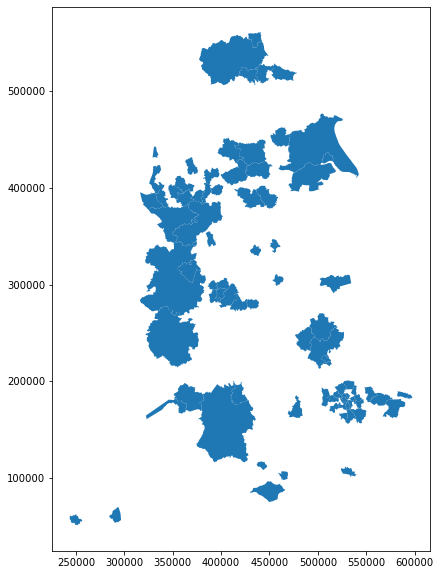

In [41]:
fig, ax = plt.subplots(figsize=(10,10))
df = gpd.GeoDataFrame(colored_df)
map_df.plot(ax =ax)